Importing the electronics dataset from the Amazon review dataset. The smaller dataset consisting of 12169 reviews were imported because of computational constraints

In [1]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Software_5.json.gz

--2021-07-14 09:12:35--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Software_5.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5339013 (5.1M) [application/octet-stream]
Saving to: ‘Software_5.json.gz’

Software_5.json.gz  100%[===================>]   5.09M  9.66MB/s    in 0.5s    

2021-07-14 09:12:35 (9.66 MB/s) - ‘Software_5.json.gz’ saved [5339013/5339013]



Importing all the dependencis

In [2]:
import os
import json
import gzip
import pandas as pd
import matplotlib
%matplotlib inline
import seaborn
from urllib.request import urlopen
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
from wordcloud import WordCloud
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Loading the JSON data and subsequently converting it into a pandas dataframe

In [3]:
data = []
with gzip.open('Software_5.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))

data_df = pd.DataFrame.from_dict(data)


### Dropping all columns which are irrelavant. 
Also labelling anything greater than or equal to 3star as 0 and lesser than that as 1. 

In [4]:
#joining the two text columns
data_df['text'] =  data_df['reviewText'] + data_df['summary']

data_df['is_bad_review'] = data_df['overall'].apply(lambda x:1 if x < 3 else 0)  

data_df.drop(columns = ['vote', 'image','verified','reviewerID','unixReviewTime','style','reviewerName','reviewTime','asin','reviewText','summary'],axis=1,inplace=True)
data_df.head()

,overall,text,is_bad_review
0,4.0,I've been using Dreamweaver (and it's predeces...,0
1,4.0,"The demo is done with the PC version, with ref...",0
2,5.0,If you've been wanting to learn how to create ...,0
3,5.0,I've been creating websites with Dreamweaver f...,0
4,5.0,I decided (after trying a number of other prod...,0


#Ratings Distribution

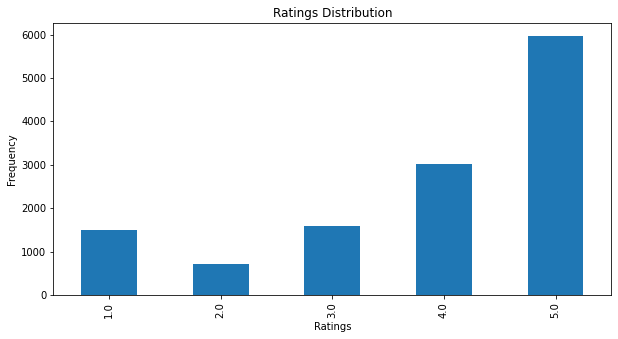

In [5]:
data_df.groupby('overall').text.count().plot.bar(figsize=(10,5), title='Ratings Distribution', colormap='tab20')
plt.xlabel("Ratings")
plt.ylabel("Frequency")
plt.show()

###Checking the ratio of positive to negative reviews in total



In [6]:
data_df["is_bad_review"].value_counts(normalize = True)

0    0.826708
1    0.173292
Name: is_bad_review, dtype: float64

#Text Preprocessing

In [7]:
#text pre-processing

from nltk.corpus import stopwords    
from textblob import Word
stoplist = set(stopwords.words('english'))

def cleaning_text(df):
    df['text'] = df['text'].str.lower().str.replace('[^\w\s]','')                                                               # Punctuation Removal
    df['text'] = df['text'].apply( lambda x: ' '.join([w for w in str(x).split() if w not in stoplist]) )                       # Removing stopwords
    df['text'] = df['text'].apply( lambda x:' '.join(x for x in x.split(" ") if not any( c.isdigit() for c in x) ) )             # Numbers Removal
    df['text'] = df['text'].apply( lambda x:' '.join(x for x in x.split(" ") if len(x) > 1) )                               # Single letter Words Removal
    df['text'] = df['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))                        # Lemmatization

cleaning_text(data_df)


Adding number of words and columns and integrating them as features

In [8]:

data_df['nb_chars'] = data_df['text'].apply(lambda x: len(str(x)))

data_df['nb_words'] = data_df['text'].apply(lambda x: len(str(x).split(" ")))



#TF-IDF column

In [9]:

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(data_df["text"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = data_df.index

data_df = pd.concat([data_df, tfidf_df], axis=1)



#Visualizing the words using WordCloud

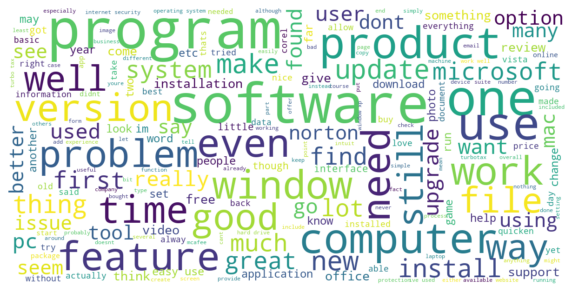

In [10]:
#WordCloud of the reviews
wordcloud = WordCloud(background_color='white',max_words = 200,  max_font_size = 40,  scale = 3,   random_state = 42).generate(' '.join(data_df['text']))  

fig = plt.figure(1, figsize = (10, 10))
fig.suptitle(None, fontsize = 10)
fig.subplots_adjust(top = 2.3)

plt.axis("off")
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

#Sentiment Analysis using SentimentIntensityAnalyser from NLTK

In [11]:

from nltk.sentiment.vader import SentimentIntensityAnalyzer


sid = SentimentIntensityAnalyzer()
data_df['sentiment_score'] = data_df['text'].apply(lambda x: sid.polarity_scores(x))
data_df = pd.concat([data_df.drop(['sentiment_score'], axis=1), data_df['sentiment_score'].apply(pd.Series)], axis=1)


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


#Visualization of Compound Score plotted over 2 lines - the Good reviews and the Bad reviews

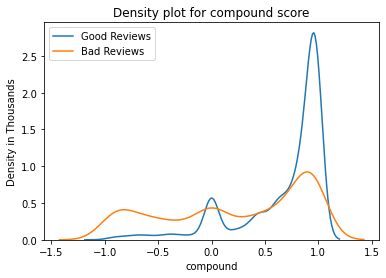

In [12]:
#Distribution of compound score
import seaborn as sns

for x in [0, 1]:
    subset = data_df[data_df['is_bad_review'] == x]
    
    # Density plot of data set
    if x == 0:
        label = "Good reviews"
        #sns.kdeplot(subset['compound'],label ='Good Reviews').set_xlim(-1,1)
        sns.kdeplot(subset['compound'],label ='Good Reviews')
    else:
        label = "Bad reviews"
        #sns.kdeplot(subset['compound'],label = 'Bad Reviews').set_xlim(-1,1)
        sns.kdeplot(subset['compound'],label = 'Bad Reviews')
        
    plt.ylabel('Density in Thousands')
    
    plt.legend()
    plt.title("Density plot for compound score")
   

#Classification of reviews using various models -



*   Gaussian Naive Bayes
*   Decision Tree Classifier
*   Random Forest Classifier



In [13]:
import time
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve
import sklearn.metrics as metrics
from time import process_time

ignore_cols = ['is_bad_review', 'overall', 'text']
features = [c for c in data_df.columns if c not in ignore_cols]

#Splitting the dataset into train and test 80-20
X_train, X_test, y_train, y_test = train_test_split(data_df[features], data_df['is_bad_review'], test_size = 0.20, random_state = 42)

models = []
models.append(('RandomForestClassifier', RandomForestClassifier()))
models.append(('GaussianNB',GaussianNB()))
models.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
accuracy=[]
time=[]
label=[]
for i,j in models:
   t=process_time()
   k=j.fit(X_train,y_train)
   y_test_pred = j.predict(X_test)
   z=(process_time() - t)
   score = metrics.accuracy_score(y_test, y_test_pred)
   accuracy.append(score*100)
   label.append(i)
   time.append(z)



#Comparsion of accuracy percentage by various classifiers

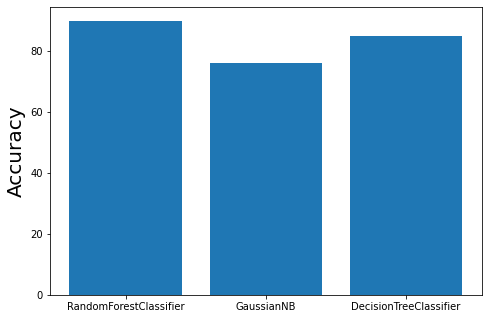

In [14]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
barlist=ax.bar(label,accuracy)
plt.ylabel('Accuracy',fontsize=20)
plt.show()
# Accuracy shown by various algorithms-> [0.9000016298320968, 0.6110894181960171, 0.8438110113237017]

#Comparision of time taken in seconds by various classifiers


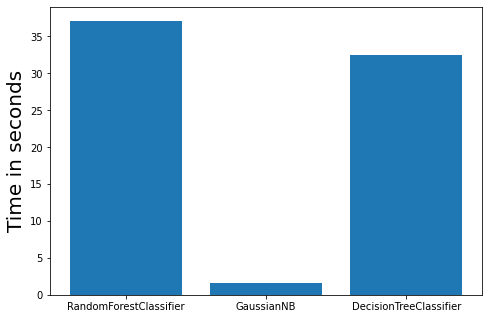

In [15]:
#Comparision of time taken in seconds by various classifiers
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
barlist=ax.bar(label,time)
plt.ylabel('Time in seconds',fontsize=20)
plt.show()
# Time taken by various algorithms ->[28.581550722999992, 0.9800993559999966, 28.451397748999995]

#Choosing Random Forest Classifier as our classification Algorithm

In [16]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

#Predicting the sentiment for the test-set
y_test_pred = rfc.predict(X_test)


#classification report
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.89      0.99      0.94      2137
           1       0.92      0.40      0.56       424

    accuracy                           0.90      2561
   macro avg       0.91      0.70      0.75      2561
weighted avg       0.90      0.90      0.88      2561



#Feature Importance

In [17]:
#Show feature importance
feature_importances_df = pd.DataFrame({"feature": features, "importance": rfc.feature_importances_}).sort_values("importance", ascending = False)
feature_importances_df.head(10)


,feature,importance
5965,compound,0.030805
5962,neg,0.027152
0,nb_chars,0.019537
5964,pos,0.018504
5963,neu,0.008527
1571,word_easy,0.007805
1,nb_words,0.007782
4994,word_star,0.006925
5630,word_useless,0.005498
2730,word_intuit,0.005132


###ROC Curve Plot

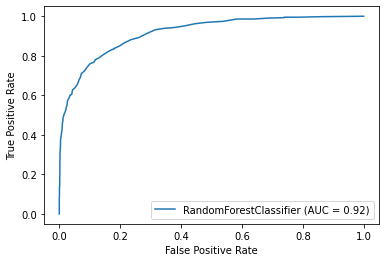

In [18]:
#ROC curve plot 
metrics.plot_roc_curve(rfc, X_test,y_test)
plt.show()

### Final Decision Path of the algorithm


In [19]:
# final decision path of the algorithm
rfc.decision_path(X_train)

(<10244x233182 sparse matrix of type '<class 'numpy.longlong'>'
 	with 76649834 stored elements in Compressed Sparse Row format>,
 array([     0,   2299,   4632,   6985,   9352,  11661,  13802,  16375,
         18604,  20989,  23326,  25539,  27846,  30177,  32646,  35069,
         37294,  39595,  41994,  44287,  46780,  49083,  51264,  53533,
         55658,  57881,  60140,  62503,  64660,  66917,  69268,  71587,
         73878,  76067,  78364,  80725,  83000,  85323,  87670,  89911,
         92286,  94561,  96914,  99143, 101384, 103749, 106042, 108477,
        110924, 113207, 115606, 117927, 120264, 122785, 125166, 127449,
        129714, 132043, 134294, 136459, 138844, 141329, 143896, 146285,
        148686, 151049, 153370, 155877, 158152, 160573, 162900, 165227,
        167404, 169979, 172442, 174837, 177226, 179589, 182032, 184403,
        186658, 188917, 191198, 193565, 195854, 198101, 200492, 202947,
        205316, 207629, 209904, 212323, 214608, 216925, 219220, 221411,
      

###Confusion Matrix

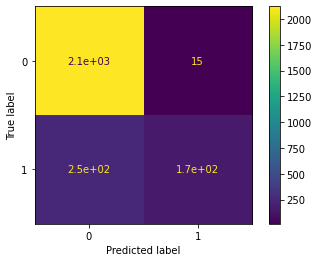

In [20]:
plot_confusion_matrix(rfc, X_test, y_test)  
plt.show()  